<a href="https://colab.research.google.com/github/raulbenitez/NEUROIMAGING_AI/blob/main/NI_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nilearn

     |████████████████████████████████| 9.6 MB 8.6 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import nibabel as nib
from nilearn.datasets import MNI152_FILE_PATH
from matplotlib import pyplot as plt
import numpy as np

# Now, we read the image with nibabel (nib), and we convert it to a numpy matrix
print(MNI152_FILE_PATH)
img = nib.load(MNI152_FILE_PATH)
data = img.get_fdata()
data.shape

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/data/mni_icbm152_t1_tal_nlin_sym_09a_converted.nii.gz


(197, 233, 189)

The data is a volume. Let's visualize a slice in z:

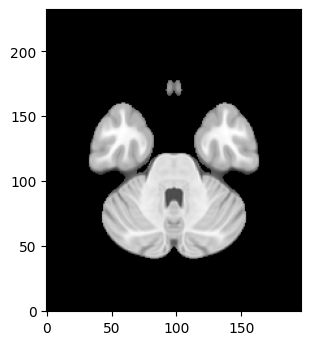

In [30]:


# Plot slice 40 (axial view). We transpose the image and set origin to lower, to see the axial representation
n_slice = 40 
I = data[:,:,n_slice].T
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
imgplot = plt.imshow(I,cmap='gray', origin='lower')

# Manual segmentation

Direct inspection of the histogram

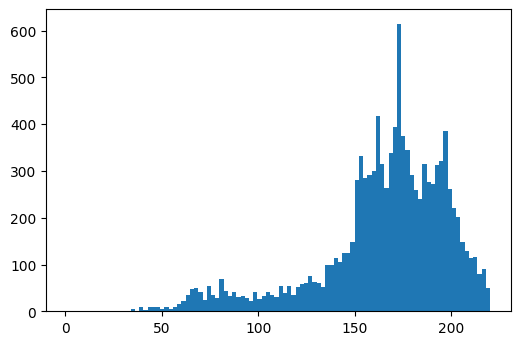

In [31]:
flat_data = I.flatten()
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

n = plt.hist(flat_data,bins=100,range=[1,flat_data.max()])
plt.show()

Apply thresholding with different thresholds

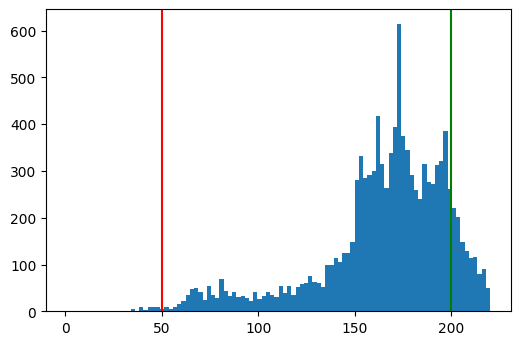

In [32]:
T1 = 50 
T2 = 200 

fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
n = plt.hist(flat_data,bins=100,range=[1,flat_data.max()])
plt.axvline(T1,color='r')
plt.axvline(T2,color='g')
plt.show()


Segment image volume applying manual thresholds (set pixels below T1 to -1 and above T2 to 1)

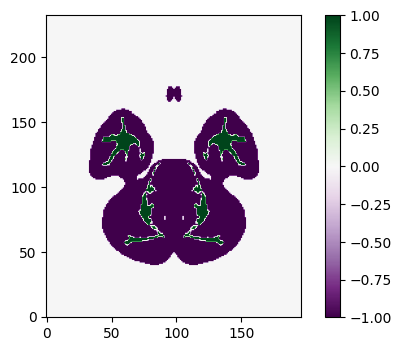

In [33]:
data_color = np.zeros(np.shape(data))
data_color[(data>T2)] = 1
data_color[(data>T1) & (data<T2)] = -1
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
imgplot = plt.imshow(data_color[:,:,40].T,cmap='PRGn', origin='lower')
plt.colorbar()
plt.show()

# Otsu thresholding
Optimal threshold separating background and foregraound structures

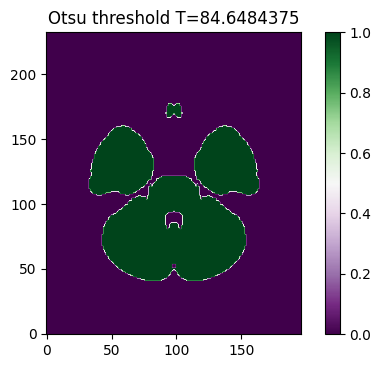

In [34]:
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

I = data[:,:,40].T
thresh = threshold_otsu(I)
binary = I > thresh

fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
imgplot = plt.imshow(binary,cmap='PRGn', origin='lower')
plt.title('Otsu threshold T={}'.format(thresh))
plt.colorbar()
plt.show()


Plot histogram with Otus's threshold

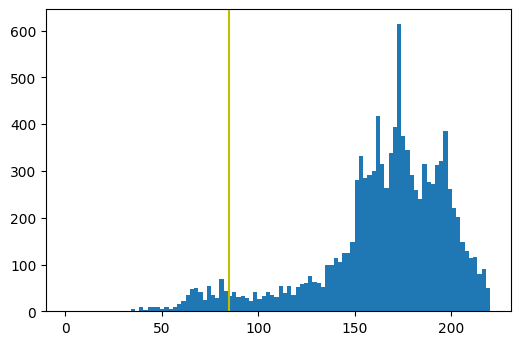

In [35]:
flat_data = I.flatten()
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
n = plt.hist(flat_data,bins=100,range=[1,flat_data.max()])
plt.axvline(thresh,color='y')
plt.show()

# Otsu multiple thresholds

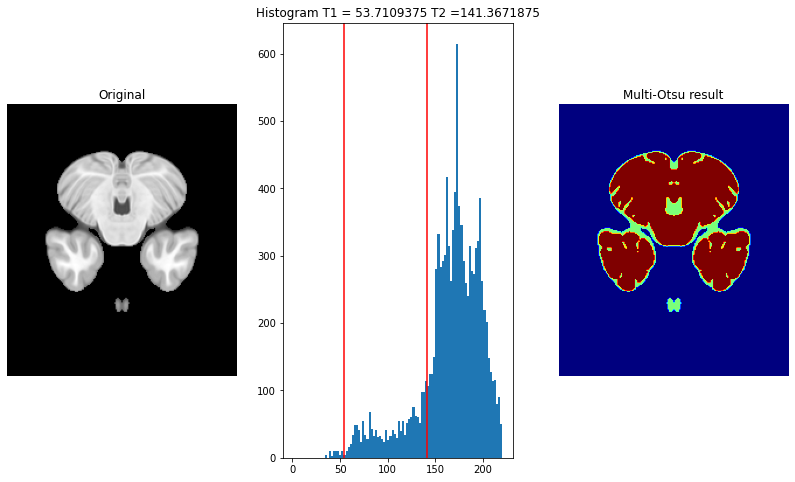

In [42]:
from skimage.filters import threshold_multiotsu

# Applying multi-Otsu threshold for the default value, generating
# three classes by default
thresholds = threshold_multiotsu(I)

# Using the threshold values, we generate the three regions.
regions = np.digitize(I, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 8))

# Plotting the original image.
ax[0].imshow(I, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(flat_data, bins=100,range=[1,flat_data.max()])
ax[1].set_title('Histogram T1 = {} T2 ={}'.format(thresholds[0],thresholds[1]))
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()
plt.show()

You can specify a larger number of regions (classes) with more thresholds: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  after removing the cwd from sys.path.


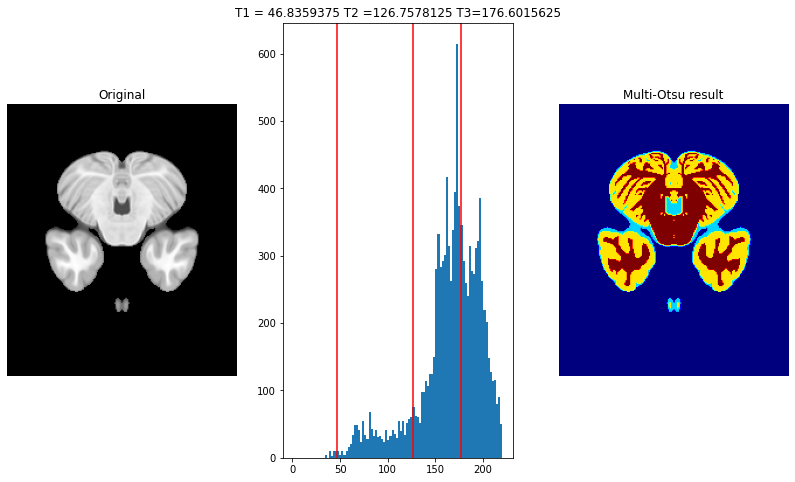

In [45]:
from skimage.color import label2rgb
thresholds = threshold_multiotsu(I, classes = 4)
regions = np.digitize(I, bins=thresholds)
regions_colorized = label2rgb(regions)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 8))

# Plotting the original image.
ax[0].imshow(I, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(flat_data, bins=100,range=[1,flat_data.max()])
ax[1].set_title('T1 = {} T2 ={} T3={}'.format(thresholds[0],thresholds[1],thresholds[2]))
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')


# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()
plt.show()

# k-means clustering

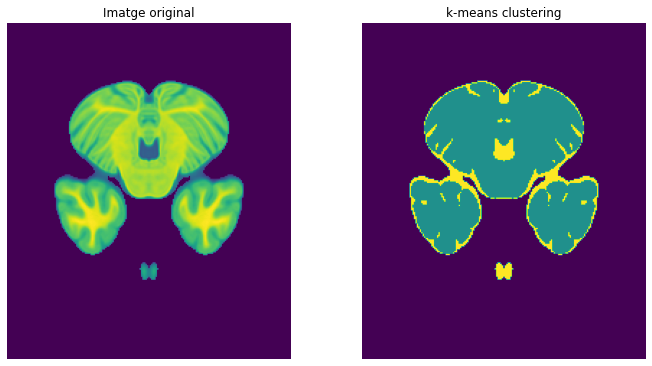

In [46]:
import skimage as sk # load skimage libraries
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import gridspec

v_I = np.reshape(I,(I.shape[0]*I.shape[1],1)) # reshape image as NPIX x NCHANNELS array
kmeans = KMeans(n_clusters=3).fit(v_I) # Fit a k-means algorithm
v_kmeans = kmeans.fit_predict(v_I) # Predict k-means cluster labels for each pixel
I_segment = np.reshape(v_kmeans,(I.shape[0],I.shape[1])) # reshape back to original image size

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0,0])
ax0.imshow(I)
ax0.set_title('Imatge original')
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(I_segment)
ax1.set_title('k-means clustering')
ax1.set_axis_off()

plt.tight_layout()
plt.show()

# Gaussian Mixture Models - Clustering

Cluster pixels using a weighted mixture of Gaussians

# $p(\vec{x}) = \sum_{i=1}^G \pi_i N(\vec{\mu_i},\Sigma)$
# $\sum_{i=1}^G \pi_i, 0\le \pi_i \le 1$

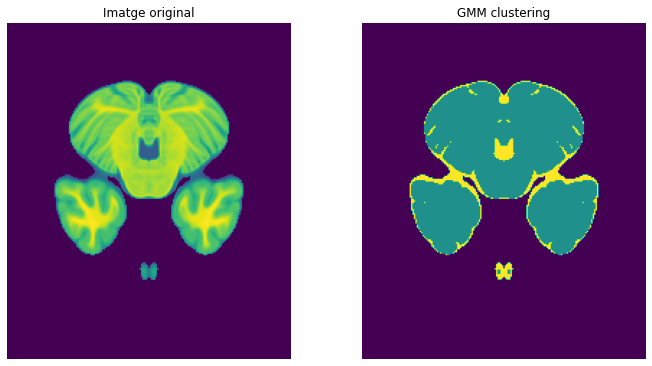

In [47]:
import skimage as sk # load skimage libraries
import numpy as np
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib import gridspec

v_I = np.reshape(I,(I.shape[0]*I.shape[1],1)) # reshape image as NPIX x NCHANNELS array
gmm = mixture.GaussianMixture(n_components=3).fit(v_I) # Fit a GMM model
v_gmm = gmm.fit_predict(v_I) # Predict GMM cluster labels for each pixel
I_segment = np.reshape(v_gmm,(I.shape[0],I.shape[1])) # reshape back to original image size

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0,0])
ax0.imshow(I)
ax0.set_title('Imatge original')
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(I_segment)
ax1.set_title('GMM clustering')
ax1.set_axis_off()

plt.tight_layout()
plt.show()

# GMM with model selection
Determine the optimal number of clusters corresponding to different structures in the image. Use Bayesian Information Criterion as a parsimony index to choose 
the optimal model (Error vs Complexity tradeoff):

$\text{BIC} = k \ln(n) - 2*\ln(\hat{\mathcal{L}})$, where

k: number of model parameters

n: number of data samples (pixels)

$\hat{\mathcal{L}}$: Maximum log-likelihood (Expectation-Maximization algorithm)

[523394.3463892296, -258966.70949776258, -262303.4561334724, -262503.52050330077, -262657.6046279824, -262677.1262009634, -262609.79689521564, -262703.9397822158, -262702.5003856085, -262696.35428380297]
...and the winner is GMM model G = 8


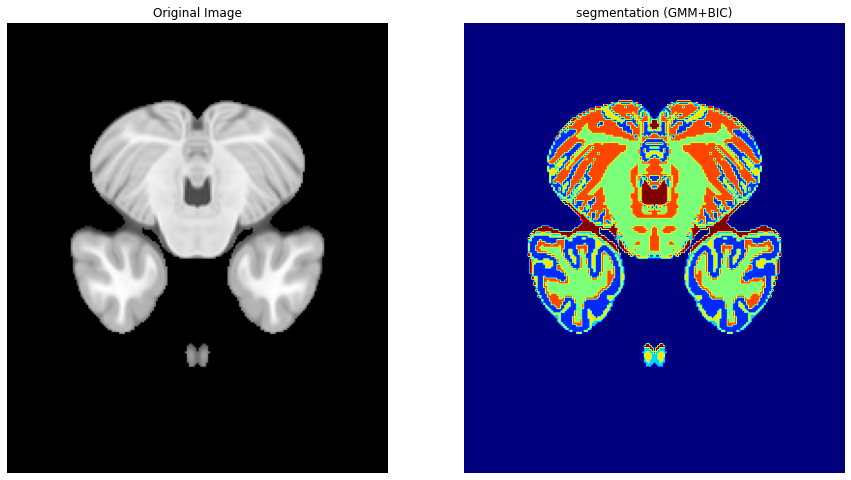

In [48]:
from skimage import io, exposure  
from sklearn.cluster import KMeans, AgglomerativeClustering
from skimage.measure import label
from skimage.transform import resize
from skimage.color import label2rgb, rgb2gray
import numpy as np
import skimage as sk 
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import mixture

#Get BIC for each GMM 
NMAX = 10
bic = []
aic = []

for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG).fit(v_I)
    bic.append(gmm.bic(v_I)) 
print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))

gmmw = mixture.GaussianMixture(n_components=idx_winner).fit(v_I)
v_agg = gmmw.fit_predict(v_I)
I_gmm = np.array(v_agg).reshape(I.shape[0],I.shape[1])# Shape back result as image

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_gmm, cmap=plt.cm.jet)
ax2.set_title('segmentation (GMM+BIC)')
ax2.set_axis_off()

plt.show()

# Segmentation using skimage libraries (gradient-based watershed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """


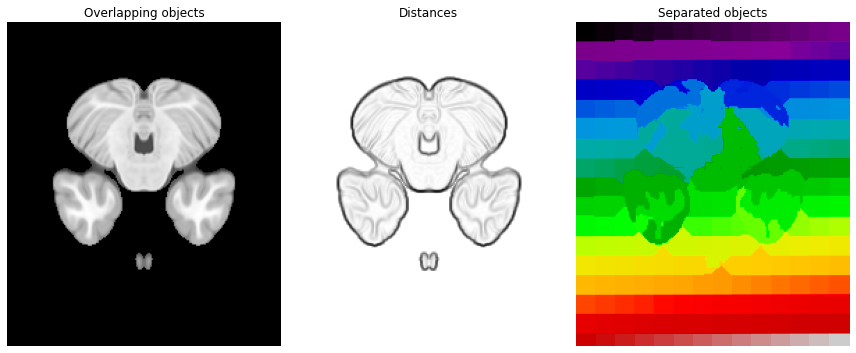

In [50]:
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed

gradient = sobel(rgb2gray(I))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

fig, axes = plt.subplots(ncols=3, figsize=(12, 12), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(I, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-gradient, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(segments_watershed, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


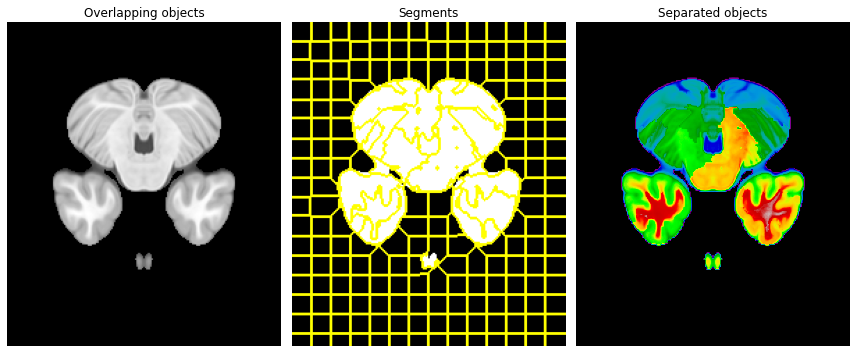

In [53]:
from skimage.segmentation import mark_boundaries

fig, axes = plt.subplots(ncols=3, figsize=(12, 12), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(I, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(mark_boundaries(I, segments_watershed))
ax[1].set_title('Segments')
ax[2].imshow(I*segments_watershed, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

Segmentation using nilearn libraries

# 3D volume segmentation

In [54]:
import skimage as sk # load skimage libraries
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import gridspec

v_I = np.reshape(data,(data.shape[0]*data.shape[1]*data.shape[2],1)) # reshape image as NPIX x NCHANNELS array
kmeans = KMeans(n_clusters=5).fit(v_I) # Fit a k-means algorithm
v_kmeans = kmeans.fit_predict(v_I) # Predict k-means cluster labels for each pixel
I_segment = np.reshape(v_kmeans,(data.shape[0],data.shape[1],data.shape[2])) # reshape back to original image size


Convert numpy array to nibabel format and visualize using nilearn functions

<Figure size 864x864 with 0 Axes>

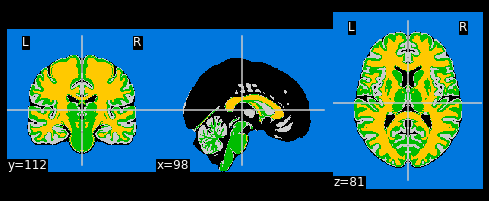

In [56]:
from nilearn.plotting import plot_epi, show
import nibabel as nib
import numpy as np

new_image = nib.Nifti1Image(I_segment, np.eye(4))
new_image.set_data_dtype(np.int64)
plot_epi(new_image)